# Kerr Microscopy

\begin{equation}
    \begin{pmatrix} E^r_s \\ E^r_p \end{pmatrix} = 
    \begin{pmatrix} r_{ss} & r_{sp} \\ r_{ps} & r_{pp} \end{pmatrix}
    \begin{pmatrix} E^i_s \\ E^i_p \end{pmatrix}
\end{equation}


In [44]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt

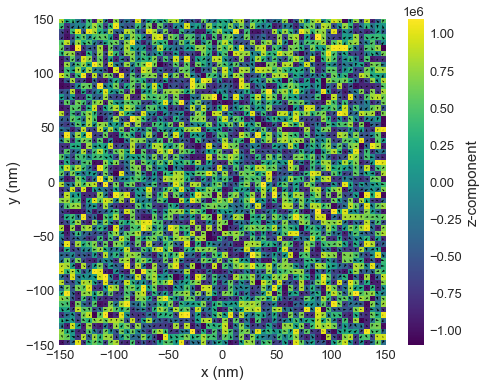

In [45]:
np.random.seed(1)
region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 5e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

In [46]:
# NBVAL_IGNORE_OUTPUT
# minimize the energy
md = oc.MinDriver()
md.drive(system)

Running OOMMF (DockerOOMMFRunner) [2021/09/14 13:08]... (11.9 s)


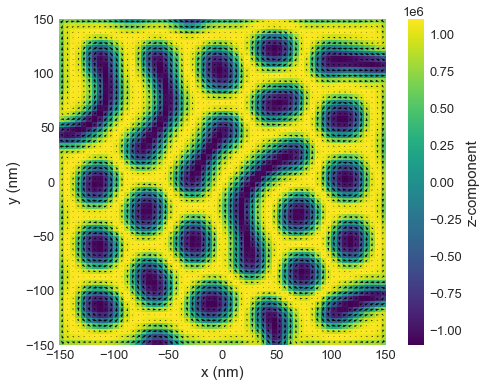

In [47]:
# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

$n_0 \sin\theta_0 = n_1 \sin\theta_1 $

\begin{equation}
    \epsilon = n^2_0 
    \begin{bmatrix}
    1 & -iQm_z & iQm_y \\
    iQm_z & 1 & -iQm_x \\
    -iQm_y & iQm_x & 1 
    \end{bmatrix}
\end{equation}

e.g.
\begin{equation}
    M = A^{-1}_0  A_1 D_1 A^{-1}_1 A_2
\end{equation}

\begin{equation}
    M = \begin{pmatrix} G & H \\ I & J \end{pmatrix}
\end{equation}

\begin{equation}
    \begin{pmatrix} r_{ss} & r_{sp} \\ r_{ps} & r_{pp} \end{pmatrix}
    = I G^{-1}
\end{equation}


\begin{equation}
    A_{j} =
    \begin{pmatrix}
    1 & 0 & 1 & 0 \\
    \frac{iQ\alpha^2_{yi}}{2} \left(m_y \frac{1+\alpha^2_{zi}}{\alpha_{yi}\alpha_{zi}} - m_z\right) & \alpha_{zi} &
    -\frac{iQ\alpha^2_{yi}}{2} \left(m_y \frac{1+\alpha^2_{zi}}{\alpha_{yi}\alpha_{zi}} + m_z\right) & -\alpha_{zi} \\
    -\frac{in_jQ}{2} \left(m_y \alpha_{yi} + m_z \alpha_{zi} \right) & -n_j &
    -\frac{in_jQ}{2} \left(m_y \alpha_{yi} - m_z \alpha_{zi} \right) & -n_j \\
    n_j\alpha_{zj} & -\frac{in_jQ}{2} \left(m_y \frac{\alpha_{yi}}{\alpha_{zi}} - m_z \right) & -n_j \alpha_{zj} &
    \frac{in_jQ}{2} \left(m_y \frac{\alpha_{yi}}{\alpha_{zi}} + m_z \right)
    \end{pmatrix}
\end{equation}

$\alpha_{yi}=\sin\theta_j, \alpha_{zi}=\cos\theta_j$

\begin{equation}
    D_{j} =
    \begin{pmatrix}
    U\cos\delta^i & U\sin\delta^i & 0 & 0 \\
    -U\sin\delta^i & U\cos\delta^i & 0 & 0 \\
    0 & 0 & U^{-1}\cos\delta^r & U^{-1}\sin\delta^r \\
    0 & 0 & -U^{-1}\sin\delta^r & U^{-1}\cos\delta^r
    \end{pmatrix}
\end{equation}

\begin{align}
    U &= \exp\left(\frac{-i2\pi n_j \alpha_{zj} d_j}{\lambda} \right)\\ 
    \delta^i &= -\frac{\pi n_j Q d_j g^i}{\lambda \alpha_{zj}} \\
    \delta^r &= -\frac{\pi n_j Q d_j g^r}{\lambda \alpha_{zj}} \\
    g^i &= m_z \alpha_{zj} + m_y \alpha_{yj} \\
    g^r &= m_z \alpha_{zj} - m_y \alpha_{yj}
\end{align}

In [66]:
n0 = 1
n_pve = 1 - 0.004 + 0.005j
n_nve = 1 - 0.006 + 0.008j
Q = 2*(n_pve - n_nve)/(n_pve+n_nve)
mx = 1
my = 1
mz = 1

e = n0**2 * np.array([[1, -1j*Q*mz, 1j*Q*my], [1j*Q*mz, 1, -1j*Q*mx], [-1j*Q*my, 1j*Q*mx, 1]])
n = np.linalg.det(np.sqrt(e))

In [76]:
def theta1(theta0, n0, n1):
    return np.arcsin((n0*np.sin(theta0))/n1)

In [123]:
def calculate_A(theta_j, nj, Q, mx, my, mz):
    a_yj = np.sin(theta_j)
    a_zj = np.cos(theta_j)
    A = [[1, 0, 1, 0],
         [(1j*Q*(1j*Q*nj)/2 * (my*a_yj + mz*a_zj)**2)/2 * (my*(1+a_zj**2)/(a_yj*a_zj) - mz), a_zj,
          -(1j*Q*a_yj**2)/2 * (my*(1+a_zj**2)/(a_yj*a_zj) + mz), -a_zj],
         [-(1j*Q*nj)/2 * (my*a_yj + mz*a_zj), -nj, -(1j*Q*nj)/2 * (my*a_yj - mz*a_zj), -nj],
         [nj*a_zj, -(1j*Q*nj)/2 * (my*a_yj/a_zj - mz), -nj*a_zj, (1j*Q*nj)/2 * (my*a_yj/a_zj + mz)]]
    return A

In [126]:
def calculate_D(theta_j, nj, Q, mx, my, mz, dj, length):
    a_yj = np.sin(theta_j)
    a_zj = np.cos(theta_j)
    gi = mz*a_zj + my*a_yj
    gr = mz*a_zj - my*a_yj
    di = -np.pi*nj*Q*dj*gi/(length*a_zj)
    dr = -np.pi*nj*Q*dj*gr/(length*a_zj)
    U = np.exp(-2j*np.pi*nj*a_zj*dj/length)
    
    D =[[U*np.cos(di), U*np.sin(di), 0, 0],
        [-U*np.sin(di), U*np.cos(di), 0, 0],
        [0, 0, np.cos(dr)/U, np.sin(dr)/U],
        [0, 0, -np.sin(dr)/U, np.cos(dr)]]
    return D

In [124]:
calculate_A(np.pi/4, 1, 1, system.m.array[..., 0],system.m.array[..., 1], system.m.array[..., 2])

[[1, 0, 1, 0],
 [array([[[-2.54902427e+17+0.j],
          [-3.52290805e+17+0.j],
          [-4.25076525e+17+0.j],
          ...,
          [-5.13429536e+17+0.j],
          [-3.97373471e+17+0.j],
          [-2.69405684e+17+0.j]],
  
         [[-3.68067508e+16+0.j],
          [-3.69538281e+16+0.j],
          [-4.74339564e+16+0.j],
          ...,
          [-1.41757929e+17+0.j],
          [-7.66555784e+16+0.j],
          [-4.95854338e+16+0.j]],
  
         [[ 4.03023802e+16-0.j],
          [ 9.37928826e+16-0.j],
          [ 1.29764046e+17-0.j],
          ...,
          [ 6.90710964e+16-0.j],
          [ 6.35184565e+16-0.j],
          [ 2.68486510e+16-0.j]],
  
         ...,
  
         [[ 6.77588809e+16-0.j],
          [ 1.39183441e+17-0.j],
          [ 1.70430862e+17-0.j],
          ...,
          [ 1.68409880e+17-0.j],
          [ 1.32503190e+17-0.j],
          [ 5.87491223e+16-0.j]],
  
         [[ 5.24160107e+16-0.j],
          [ 1.03625444e+17-0.j],
          [ 1.25558406e+17-0.j],
 

In [127]:
calculate_D(np.pi/12, 1, 1, system.m.array[..., 0],system.m.array[..., 1], system.m.array[..., 2], 1, 1)

[[array([[[ 0.88304333+0.19199707j],
          [-0.38111228-0.08286393j],
          [ 0.77912037+0.16940146j],
          ...,
          [ 0.78843211+0.17142608j],
          [-0.67742172-0.14728947j],
          [ 0.75477149+0.16410737j]],
  
         [[ 0.97209506+0.21135928j],
          [-0.20716373-0.0450429j ],
          [-0.01824992-0.00396802j],
          ...,
          [ 0.22106672+0.04806578j],
          [ 0.04296132+0.00934093j],
          [ 0.95314418+0.20723886j]],
  
         [[ 0.93831218+0.20401399j],
          [ 0.97169868+0.2112731j ],
          [-0.76134071-0.16553569j],
          ...,
          [ 0.03286264+0.00714521j],
          [-0.86683681-0.18847335j],
          [ 0.06034946+0.01312157j]],
  
         ...,
  
         [[ 0.92919973+0.2020327j ],
          [-0.96830706-0.21053567j],
          [-0.43326655-0.09420366j],
          ...,
          [ 0.51282513+0.1115018j ],
          [-0.34062717-0.07406139j],
          [ 0.88714352+0.19288856j]],
  
         [[-0.78629